# Example of running Algoithmia FEWS
This note book sets out a worked example of the FEWS algorithim on the Algorithmia platform. The primary aim is to demonstrate how to make a call to the platform and to extract the results.


## Set up the enviroment

In [14]:
# Install required modules:
import sys
!{sys.executable} -m pip install Algorithmia
!{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install json   # Doesn't require installation
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib


import Algorithmia
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import math

%matplotlib inline 
sns.set(style="whitegrid")

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Load and view the data

In [20]:
synt = pd.read_csv("./Syntethic data.csv")
synt.head()

,month_num,char11,char1,char2,char3,char4,char5,char6,char7,char8,char9,char10,prodid_num,quantity,value
0,0,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,280,196420
1,1,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,126,85312
2,2,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,148,95920
3,3,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,56,38552
4,4,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,69,47397


## Tidy the data for Algothmia
To run the data on algorithmia the data must be coereced into a data frame with the following column names:
* **times** The times should be numeric types at this stage in the development. Algorithmia will throw an error if a datetime class is used.
* **logprice** The natual log of the unit prices
* **id** The unique id of each product. Can be a string or numeric type
* **weight** The expenditure weights of each entry. These should be in the form of expanediture share i.e. normalised by each time period to avoid introducing bias in to the model.






### Drop unncecessary variables
The synthetic data has product charictaristics information which is not required for the FEWS. All of these columns start with "char"

In [21]:
# Drop all of the charictaristics columns as these are not required
synt = synt.loc[:, ~synt.columns.str.startswith('char')]

## Make unit value and log of unit value columns
The unit value column is only used for visualising the data

In [22]:
# Get the unit price, and then find the log price. Do this in 2 steps for data vis
synt['unit_price'] = synt.apply(lambda row: (row["value"] / row["quantity"]) ,axis = 1)
synt['logprice'] = synt.apply(lambda row: math.log(row["value"] / row["quantity"]), axis = 1)
synt.head()

,month_num,prodid_num,quantity,value,unit_price,logprice
0,0,3,280,196420,701.500000,6.553221
1,1,3,126,85312,677.079365,6.517788
2,2,3,148,95920,648.108108,6.474058
3,3,3,56,38552,688.428571,6.534412
4,4,3,69,47397,686.913043,6.532208


## Visualise the price data
Due to the large number of prices this is a little unclear

/opt/continuum/anaconda/envs/lab_launch/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


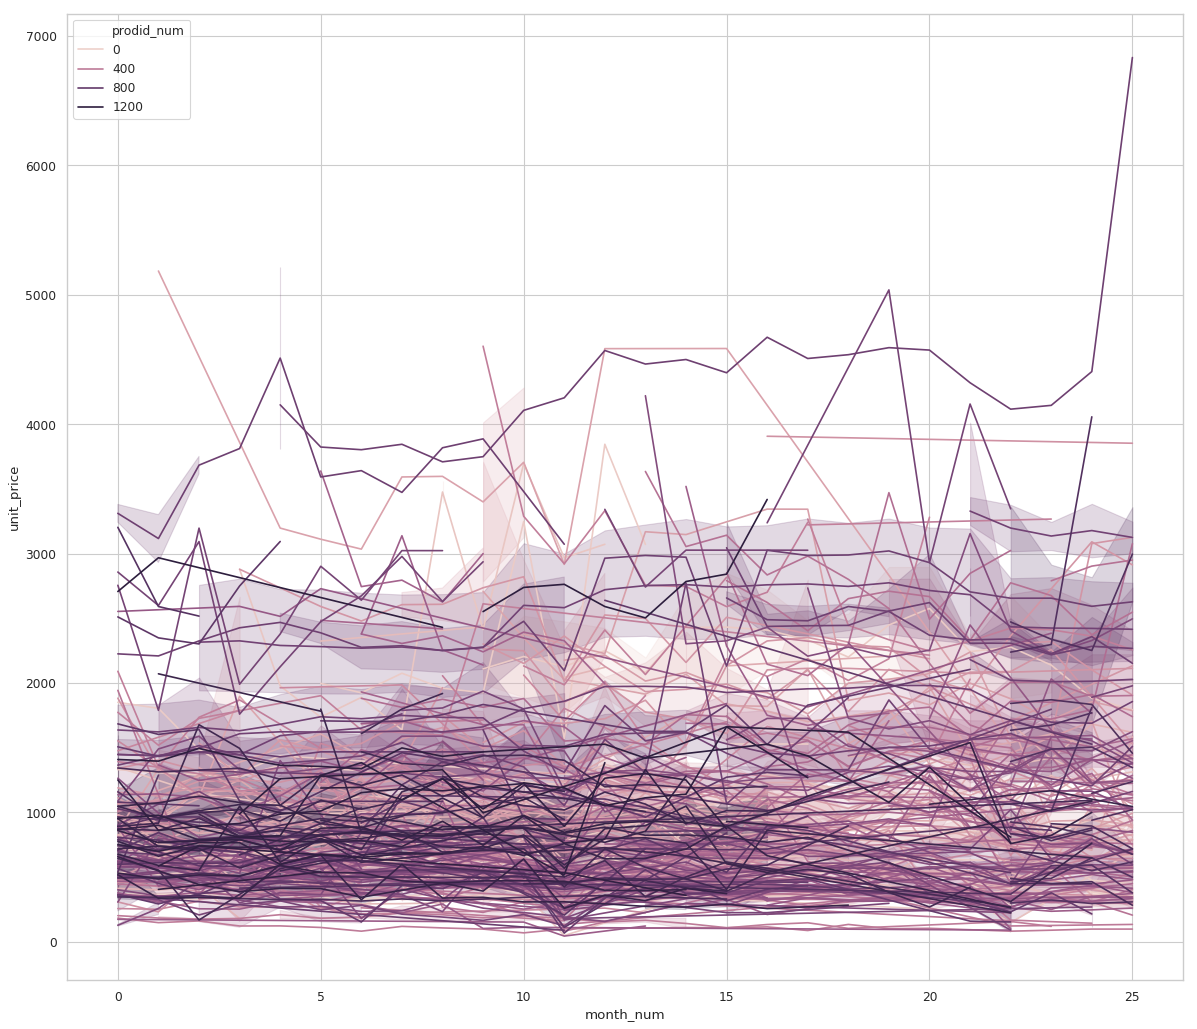

In [23]:

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

g = sns.lineplot(x = "month_num",
                 y = "unit_price",
                 data = synt,
                 hue = "prodid_num")   
plt.show()



## Make a weight column
The weights calculated by the expenditure share of each time period, to prevent bias in the model.


In [24]:
# Make a weight column which is the expenditure share of each month.
monthly_value = synt.groupby("month_num", as_index = False).agg({"value":"sum"})

# Merge the monthly totals col back on to the original dataset
synt = synt.merge(monthly_value,
                  left_on = "month_num",
                  right_on = "month_num",
                  how = "left")

# Make the weight col by dividing each value by the total for that month
synt['weight'] = synt.apply(lambda row: (row["value_x"] / row["value_y"]) ,
      axis = 1)


## Make a new copy of the dataframe
Copy the data frame, othersiwe the unit price column would be lost. We may want to go back and look at it later. Copy the data frame, drop the unrequired columns and rename the columns to match the requirements of algorighmia. Some of the columns are already have the correct names for Algorithmia, so they are not renamed here.

In [25]:
synt_copy = synt.copy()

# Drop unnecessary columns as the dataframe will be sent to algoithmia
synt_copy = synt_copy.drop(["quantity","value_x", "unit_price", "value_y"], axis = 1)
synt_copy = synt_copy.rename(columns={'prodid_num': 'id', 'month_num': 'times'})


## Wrap the data from into a json for Algorithmia
This is where window length and the splice method are chosen

In [26]:
# first build the data into a dict
synt_dict = synt_copy.to_dict(orient = "list")
# add the other argument to the json
synt_dict['window_length'] = 10
synt_dict['splice_pos'] = 'mean'
# write the json           
synt_json = json.dumps(synt_dict)

# Call the FEWS function
API key: For security I have created a an API key which can only call the FEWS algorithium and has only got read access. If you need to call any other algorithiums you will need to change the API key.

In [38]:
my_API_key = 'simxPsAMv0M7XII9LTaaY+CDmcv1'

client = Algorithmia.client(my_API_key,
'https://api.methods.officialstatistics.org')
algo = client.algo('donal_lynch/FEWS/0.1.4')
output = algo.pipe(synt_json)
# Conver the result from a string to a dict
output_dict = json.loads(output.result)

In [32]:
# Extract all of the data:
synt_fews = pd.DataFrame(output_dict['fews'])
synt_fixed_effects = pd.DataFrame(output_dict['fixed_effects'])
synt_diagnostics = pd.DataFrame(output_dict['diagnostics'])

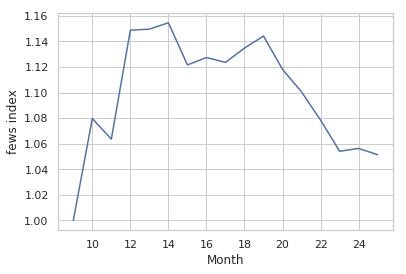

In [33]:
g = sns.lineplot(x = "price_date",
                  y = "fe_indexes",
                  data = synt_fews)
g.set(xlabel='Month', ylabel='fews index')
plt.show()

## What else is returned by Algorithmia

### synt_fixed_effects
This data frame contains the fixed effects for each window, before they have been spliced together. This can be useful for debugging any strange movements.
The number of rows is the window length  * the number of windows in the data


In [104]:
synt_fixed_effects.head()

,fe_indexes,price_date,window_id
0,1.0000,0,1
1,0.9655,1,1
2,0.9926,2,1
3,0.9895,3,1
4,1.0025,4,1


In [105]:
synt_fixed_effects.describe(percentiles = [])

,fe_indexes,price_date,window_id
count,170.000000,170.000000,170.000000
mean,1.031647,12.500000,9.000000
std,0.066840,5.695685,4.913452
min,0.908300,0.000000,1.000000
50%,1.007150,12.500000,9.000000
max,1.170500,25.000000,17.000000


### Diagnostic Results:
The fews returns a diagnostics dataframe which has 1 row for each of the windows inteh data frame, and the following columns:
#### contrib_rids_pc
the % of ids which exist in the window and contribute to the index. An id can only contribute to then index if it has at least 2 prices in the window.
#### contrib_rids_nm
the number of ids which exist in the window that contribute
#### total_rids_in_data
number of ids in the entire dataset
#### total_rids_in_window
number of ids which have any prices in the window
#### num_records_in_window
The number of rows of data in this window
#### QU_1st 
25% of the id's have less than this many prices in the window
#### gm_mean_entries_per_rid
the geometric mean number of prices per id in this window
#### mean_entries_per_rid
the mean number of prices per rid in this window
#### median_entries_per_rid
the median number of prices per rid in this window
#### QU_3rd
75% of the id's have less than this many prices in the window
#### window_id
identifier for the window

In [40]:
synt_diagnostics.head()

,QU_1st,QU_3rd,contrib_rids_nm,contrib_rids_pc,gm_mean_entries_per_rid,mean_entries_per_rid,median_entries_per_rid,num_records_in_window,total_rids_in_data,total_rids_in_window,window_id
0,2.00,10.0,219,80.2198,4.9948,8.1026,6,2212,0,273,1
1,2.00,10.0,225,83.9552,5.2760,8.2537,7,2212,0,268,2
2,2.00,10.0,228,82.3105,5.1805,8.2238,7,2278,0,277,3
3,2.00,10.0,240,84.8057,5.1767,8.1484,6,2306,0,283,4
4,2.75,10.0,241,83.6806,5.0953,8.0764,6,2326,0,288,5


## More information
More information on all of the results can be found by installing the FEWS package in R. <br>
Run the Following commands in R to view the documentation:<br>
`devtools::install_github("Donal-lynch/FEWS_package")` <br>
`library(FEWS)` <br>
`?FEWS`
